### The task is to predict house prices in Ames, Iowa using 79 predictor (explanatory) variables using machine learning. So this is a regression problem.

Hypothesis generation, in general, is to create a set of features that should impact the target variable given a confidence interval (taken as 95% all the time). We should do this before looking at the data to avoid biased thoughts. This step often helps in creating new features.


<br>The features that may be should have an impact on the price of the house are:
* Area the house has been built on.
* Number of floors it has.
* Number of bedrooms it has.
* How old is the house.
* Materials used to build the house
* Location of the house.
* How close/far is the house off the market, and so on.

Importing packages and collecting data:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')                    
sns.set_style({'axes.grid':False}) 

import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected = True) # Required to use plotly offline in jupyter notebook

from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
bold('**Shape of our train and test data:**')
display(train.shape, test.shape)

**Shape of our train and test data:**

(1460, 81)

(1459, 80)

We can see total 81 variables for train and 80 variables for test data. And we don't have SalePrice variable for test set because this will be our task to infer SalePrice for test set by learning from train set. So SalePrice is our target variable and rest of the variables are our predictor variables.

Inspecting variables one by one to separate categorical variables from numerical variables will take so much time. Hence we will extract nominal variables from numerical variables using pandas select_dtypes method and then visualize them using histogram (for continuous variables) or bar chart (for nominal and discrete variables) to make sure pandas select_dtypes method isn't misleading us.

In [5]:
# How many kinds of data types that we have to deal with

merged = pd.concat([train, test], axis = 0, sort = True)
bold('**Data types of our variables:**')
display(merged.dtypes.value_counts())

**Data types of our variables:**

object     43
int64      26
float64    12
dtype: int64

In [6]:
# Extract numerical variables

num_merged = merged.select_dtypes(include = ['int64', 'float64'])
bold('**Name of numerical variables:**')
display(num_merged.columns.values)

**Name of numerical variables:**

array(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea',
       'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Id',
       'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF',
       'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF',
       'OverallCond', 'OverallQual', 'PoolArea', 'SalePrice',
       'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF',
       'YearBuilt', 'YearRemodAdd', 'YrSold'], dtype=object)

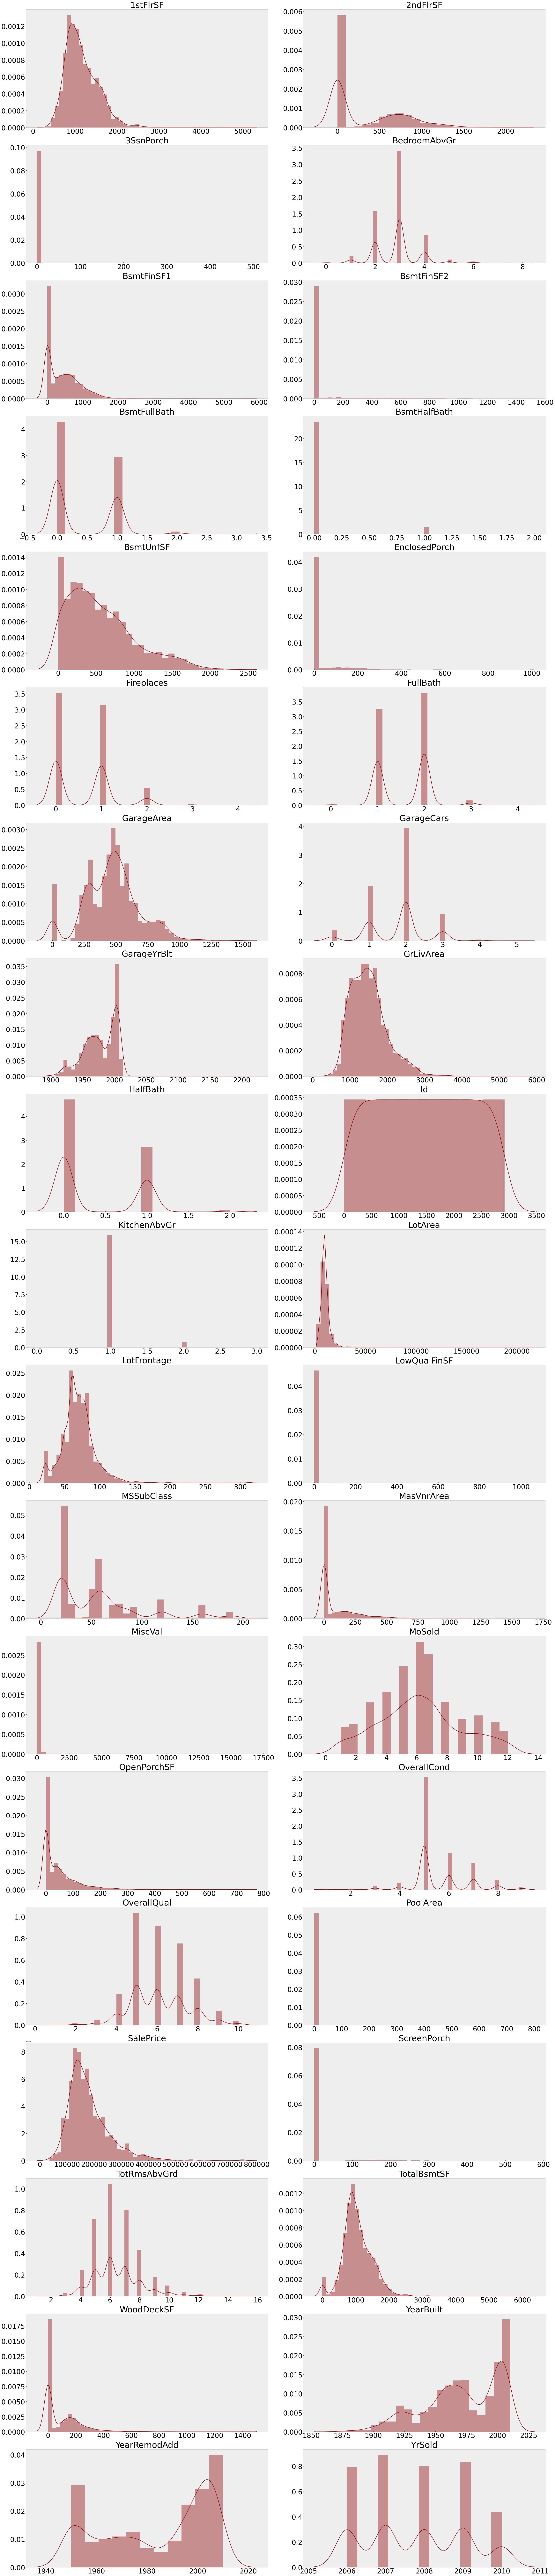

In [7]:
# Plot histogram of numerical variables to validate pandas intuition

fig, axes = plt.subplots(nrows = 19, ncols = 2, figsize = (40, 200))

for ax, column in zip(axes.flatten(), num_merged.columns):
    sns.distplot(num_merged[column].dropna(), ax = ax, color = 'darkred')
    
    ax.set_title(column, fontsize = 43)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 35)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 35)
    ax.set_xlabel('')
    
fig.tight_layout(rect = [0, 0.03, 1, 0.95])

Well we can clearly see some distributions are continuous (like LotFrontage, LotArea, and YearBuilt) and some are discrete (like MSSubClass, OverallQual, OverallCond, BsmtFullBath, and HalfBath etc.). Let's correct the data types accordingly. Reading data description we see some variables are actually categorical (like like MSSubClass, OverallQual, and OverallCond). Hence we would explicitly cast them into categorical variables. 

In [8]:
# Convert MSSubClass, OverallQual, OverallCond, MoSold, YrSold into categorical variables

merged.loc[:, ['MSSubClass', 
               'OverallQual', 
               'OverallCond', 
               'MoSold', 
               'YrSold']] = merged.loc[:, ['MSSubClass', 
                                           'OverallQual', 
                                           'OverallCond', 
                                           'MoSold', 
                                           'YrSold']].astype('object')

In [9]:
# Check out the data types after correction

bold('**Data types after correction:**')
display(merged.dtypes.value_counts())

**Data types after correction:**

object     48
int64      21
float64    12
dtype: int64

In [10]:
# Extract train and test data from the combined data set

df_train = merged.iloc[:1460, :].drop(columns = ['Id'], axis = 1)
df_test = merged.iloc[1460:, :].drop(columns = ['Id', 'SalePrice'], axis = 1) # SalePrice due to concatenation

---

### Outliers Treatment

3 functions for different Plotly plots:

In [11]:
'''Function to plot bar chart'''
def bar_plot(x, y, title, yaxis, c_scale):
    trace = go.Bar(x = x,
                   y = y,
                   marker = dict(color = y, 
                                 colorscale = c_scale))
    layout = go.Layout(hovermode= 'closest', 
                       title = title, 
                       yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], 
                    layout = layout)
    
    return iplot(fig)

In [12]:
'''Function to plot scatter plot'''
def scatter_plot(x, y, title, xaxis, yaxis, size, c_scale):
    trace = go.Scatter(x = x,
                       y = y,
                       mode = 'markers',
                       marker = dict(color = y, 
                                     size = size, 
                                     showscale = True, 
                                     colorscale = c_scale))
    layout = go.Layout(hovermode= 'closest', 
                       title = title, 
                       xaxis = dict(title = xaxis), 
                       yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], 
                    layout = layout)
    
    return iplot(fig)    

In [13]:
'''Function to plot histogram'''
def plot_histogram(x, title, yaxis, color):
    trace = go.Histogram(x = x,
                         marker = dict(color = color))
    layout = go.Layout(hovermode= 'closest', 
                       title = title, 
                       yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], 
                    layout = layout)
    
    return iplot(fig)

There is a Special Notes in data documentation that says, "*There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students*".

Let's plot a scatter plot of GrLivArea vs SalePrice first to treat the outliers mentioned:

In [14]:
scatter_plot(df_train.GrLivArea, 
             df_train.SalePrice, 
             'GrLivArea vs SalePrice', 
             'GrLivArea', 
             'SalePrice', 
             10, 
             'Rainbow')

In [15]:
# Drop observations where GrLivArea is greater than 4000 sq.ft

df_train.drop(df_train[df_train.GrLivArea>4000].index, inplace = True)
df_train.reset_index(drop = True, inplace = True)

In [16]:
scatter_plot(df_train.GrLivArea, 
             df_train.SalePrice, 
             'GrLivArea vs SalePrice', 
             'GrLivArea', 
             'SalePrice', 
             10, 
             'Rainbow')

### Imputing Missing Variables

The simpliest way to impute missing values of a variable is to impute its missing values with its mean, median or mode depending on its distribution and variable type(categorical or numerical). By now, we should have a idea about the distribution of the variables and the presence of outliers in those variables. For categorical variables mode-imputation is performed and for numerical variable mean-impuation is performed if its distribution is symmetric(or almost symmetric or normal like Age). On the other hand, for a variable with skewed distribution and outliers, meadian-imputation is recommended as median is more immune to outliers than mean.

<br>However, one clear disadvantage of using mean, median or mode to impute missing values is the addition of bias if the amount of missing values is significant. So simply replacing missing values with the mean or the median might not be the best solution since missing values may differ by groups and categories. To solve this, we can group our data by some variables that have no missing values and for each subset compute the median to impute the missing values of a variable.

For this purpose we would merge train and test data together. This will eliminate the hassle of handling train and test data separately thought it might induce some data leakage problem. But in practice, we would not have any test data during model training, so data leakage problem in real world could be avoided. Moreover, all the preprocessings done combinedly lead to better a leaderboard score (may be due to data leakage).

In [17]:
# Separate our target variable first
y_train = df_train.SalePrice

# Drop SalePrice from train data
df_train.drop('SalePrice', axis = 1, inplace = True)

# Now combine train and test data frame together
df_merged = pd.concat([df_train, df_test], axis = 0)

In [18]:
# Columns with missing observations
missing_columns = df_merged.columns[df_merged.isnull().any()].values

# Number of columns with missing observations
total_columns = np.count_nonzero(df_merged.isna().sum())

print('We have ' , 
      total_columns ,  
      'features with missing values and those features (with missing values) are: \n\n' , 
      missing_columns)

We have  34 features with missing values and those features (with missing values) are: 

 ['Alley' 'BsmtCond' 'BsmtExposure' 'BsmtFinSF1' 'BsmtFinSF2'
 'BsmtFinType1' 'BsmtFinType2' 'BsmtFullBath' 'BsmtHalfBath' 'BsmtQual'
 'BsmtUnfSF' 'Electrical' 'Exterior1st' 'Exterior2nd' 'Fence'
 'FireplaceQu' 'Functional' 'GarageArea' 'GarageCars' 'GarageCond'
 'GarageFinish' 'GarageQual' 'GarageType' 'GarageYrBlt' 'KitchenQual'
 'LotFrontage' 'MSZoning' 'MasVnrArea' 'MasVnrType' 'MiscFeature' 'PoolQC'
 'SaleType' 'TotalBsmtSF' 'Utilities']


Get and plot only the features (with missing values) and their corresponding missing values:

In [19]:
missing_columns = len(df_merged) - df_merged.loc[:, np.sum(df_merged.isnull())>0].count()

x = missing_columns.index
y = missing_columns

title = 'Variables with Missing Values'
scatter_plot(x, 
             y, 
             title, 
             'Features Having Missing Observations',
             'Missing Values', 
             30, 
             'Picnic')

Usually we drop a variable if at least 40% of its values are missing. Hence, one might tempt to drop variables like PoolQC, MiscFeature, Alley, Fence, and FirePlaceQu. Deleting these variables would be a blunder because data description tells these 'NaN' has some purpose for those variables. Like 'NaN' in PoolQC refers to 'No Pool', 'NaN' in MiscFeature refers to 'None', and 'NaN' in Alley means 'No alley access' etc. More generally NaN means the absent of that variable. 

Hence we gonna replace NaN with 'None' in those variable:

In [20]:
# Impute by None where NaN means something

to_impute_by_none = df_merged.loc[:, ['PoolQC',
                                      'MiscFeature',
                                      'Alley', 
                                      'Fence', 
                                      'FireplaceQu', 
                                      'GarageType', 
                                      'GarageCond',
                                      'GarageFinish',
                                      'GarageQual',
                                      'BsmtFinType2',
                                      'BsmtExposure',
                                      'BsmtQual',
                                      'BsmtCond',
                                      'BsmtFinType1',
                                      'MasVnrType']]
for i in to_impute_by_none.columns:
    df_merged[i].fillna('None', inplace = True)

These are categorical variables and will be imputed by mode:

In [21]:
to_impute_by_mode = df_merged.loc[:, ['Electrical', 
                                      'MSZoning',
                                      'Utilities',
                                      'Exterior1st',
                                      'Exterior2nd',
                                      'KitchenQual',
                                      'Functional', 
                                      'SaleType']]
for i in to_impute_by_mode.columns:
    df_merged[i].fillna(df_merged[i].mode()[0], inplace = True)

The following variables are either discrete numerical or continuous numerical variables.So the will be imputed by median:

In [22]:
to_impute_by_median = df_merged.loc[:, ['BsmtFullBath',
                                        'BsmtHalfBath', 
                                        'GarageCars', 
                                        'MasVnrArea', 
                                        'GarageYrBlt', 
                                        'BsmtFinSF1', 
                                        'BsmtFinSF2', 
                                        'BsmtUnfSF', 
                                        'TotalBsmtSF', 
                                        'GarageArea']]
for i in to_impute_by_median.columns:
    df_merged[i].fillna(df_merged[i].median(), inplace = True)

In [23]:
#Columns remaining to be imputed

display(df_merged.columns[df_merged.isna().any()].values)

array(['LotFrontage'], dtype=object)

Almost 17% observations of LotFrontage are missing in. 

Hence, simply imputing LotFrontage by mean or median might introduce bias since the amount of missing values is significant. Again LotFrontage may differ by different categories of house. To solve this, we can group our data by some variables that have no missing values and for each subset compute the median LotFrontage to impute the missing values of it. This method may result in better accuracy without high bias, unless a missing value is expected to have a very high variance.

Let's create a function to find the variables correlated with LotFrontage:

In [24]:
from sklearn.preprocessing import LabelEncoder

In [25]:
def corr(correlation, variable):
    correlation = correlation.agg(LabelEncoder().fit_transform)
    correlation['LotFrontage'] = variable
    corr = correlation.corr()
    
    display(corr['LotFrontage'].sort_values(ascending = False)[:5])
    display(corr['LotFrontage'].sort_values(ascending = False)[-5:])

In [26]:
# Correlation of LotFrontage with categorical data

bold("**LotFrontage's correlation with categorical data:**")
corr(df_merged.select_dtypes(include = ['object']), df_merged.LotFrontage)

**LotFrontage's correlation with categorical data:**

LotFrontage     1.000000
OverallQual     0.204049
RoofStyle       0.180168
Exterior2nd     0.130137
Neighborhood    0.124097
Name: LotFrontage, dtype: float64

LotConfig    -0.191358
GarageType   -0.294884
MSSubClass   -0.396307
BldgType     -0.485279
Utilities          NaN
Name: LotFrontage, dtype: float64

BldgType has the highest correlation with LotFrontage. So the tactic is to impute missing values of LotFrontage with the median LotFrontage of similar rows according BldgType.

In [27]:
df_merged.LotFrontage = df_merged. \
                            groupby(['BldgType'])['LotFrontage']. \
                                transform(lambda x: x.fillna(x.median()))

In [28]:
# Is there any missing values left untreated?

print('Missing variables left untreated: ', df_merged.columns[df_merged.isna().any()].values)

Missing variables left untreated:  []


Okay, we're also done with imputation.

---

### Transformation of Distributions

Normal distribution (bell-shaped) of variables is not only one of the assumptions of regression problems but also a assumption of parametric test (like one-way-anova, t-test etc) and pearson correlation. But in practice, this can not be met perfectly and hence some deviation off this assumption is acceptable. In this section, we would try to make the skewed distribution as normal as possible. Since most of the variables are positively skewed, we would apply log transformation on them. 

Let's observe our target variable separately:

In [29]:
# Plot the distribution of SalePrice with skewness

title = 'SalePrice without Transformation (skewness: {:0.4f})'.format(y_train.skew())
plot_histogram(y_train, title, 'Abs Frequency', 'darkred')

In [30]:
# Plot the distribution of SalePrice removing skewness

y_train = np.log1p(y_train)
title = 'SalePrice after Transformation (skewness: {:0.4f})'.format(y_train.skew())
plot_histogram(y_train, title, 'Abs Frequency', 'green')

Now calculate and plot the skewness for rest of the explanetory variables:

In [31]:
skew_merged = pd.DataFrame(data = df_merged.select_dtypes \
                               (include = ['int64', 'float64']).skew(), 
                           columns = ['Skewness'])
skew_merged_sorted = skew_merged.sort_values(ascending = False, 
                                             by = 'Skewness')

bar_plot(skew_merged_sorted.index, 
         skew_merged_sorted.Skewness, 
         'Skewness in Explanetory Variables', 
         'Skewness', 
         'Bluered')

In [32]:
# Extract numeric variables merged data

df_merged_num = df_merged.select_dtypes(include = ['int64', 'float64'])

In [33]:
# Get the index of the data to be transformed

bold('**Features to be transformed (skewness > 0.75):**')
display(df_merged_num.skew()[df_merged_num.skew()>0.75].index.values) 

**Features to be transformed (skewness > 0.75):**

array(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'GrLivArea',
       'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF',
       'MasVnrArea', 'MiscVal', 'OpenPorchSF', 'PoolArea', 'ScreenPorch',
       'WoodDeckSF'], dtype=object)

In [34]:
# Make the transformation

df_merged_skewed = np.log1p(
                            df_merged_num[
                                          df_merged_num.skew()[
                                                               df_merged_num.skew() > 0.75
                                                               ].index
                                         ]
                            )
df_merged_normal = df_merged_num[
                                 df_merged_num.skew()[
                                                      df_merged_num.skew() < 0.75
                                                     ].index
                                ]
df_merged_num_all = pd.concat([df_merged_skewed, 
                               df_merged_normal], 
                              axis = 1)

In [35]:
# Update numerical variables with transformed variables

df_merged_num.update(df_merged_num_all)

In [36]:
# Plot the distribution of SalePrice with skewness

title = 'SalePrice with Transformed Variable (skewness: {:0.4f})'.format(y_train.skew())
plot_histogram(y_train, title, 'Abs Frequency', 'darkred')

---

### Bivariate Analysis

Being the most important part, bivariate analysis tries to find the relationship between two variables. We will look for correlation or association between our predictor and target variables. Bivariate analysis is performed for any combination of categorical and numerical variables. The combination can be: Numerical & Numerical, Numerical & Categorical and Categorical & Categorical.

For numeric-numeric combination, we would use scatter plot to analyse how strong the correlation is. And for numeric-categorical combinbation, we would use boxplot to see if there is any association between our target and explanatory variables. Since we're dealing with 79 predictor variables, it would not be a good idea to analyse all the variables one by one to find any correlation with SalePrice. We would anylyse only 20 variables that are highly correlated (either positive or negative) with SalePrice.

As there are some categorical variables, we need to fit label encoder to have their correlation with target variable and based on this correlation value, we would only choose 20 variables that have the highest correlation (either positive or negative) for further anlysis.

In [37]:
# Fit label encoder to find the correlated variables

f_corr = pd.concat([df_merged.iloc[0:1456, :], 
                    y_train], 
                   axis = 1)
df_corr = f_corr.agg(LabelEncoder().fit_transform)
df_corr = df_corr.corr()

bold('**Best 10 Positively Correlated Variables:**')
display(df_corr['SalePrice'].sort_values(ascending = False)[:11]) # Best 10 positively correlated
bold('**Best 10 Negatively Correlated Variables:**')
display(df_corr['SalePrice'].sort_values(ascending = False)[-10:]) # Best 10 negatively correlated

**Best 10 Positively Correlated Variables:**

SalePrice       1.000000
OverallQual     0.819885
GrLivArea       0.737118
GarageCars      0.680034
GarageArea      0.664054
TotalBsmtSF     0.633474
YearBuilt       0.618314
FullBath        0.616308
1stFlrSF        0.599499
YearRemodAdd    0.580152
GarageYrBlt     0.532280
Name: SalePrice, dtype: float64

**Best 10 Negatively Correlated Variables:**

KitchenAbvGr   -0.161072
MSZoning       -0.232167
LotShape       -0.292313
BsmtExposure   -0.303445
HeatingQC      -0.448559
GarageFinish   -0.449363
GarageType     -0.513152
KitchenQual    -0.554800
BsmtQual       -0.598646
ExterQual      -0.611179
Name: SalePrice, dtype: float64

We can also create a scatter plot matrix of positively correlated variables (top 5) with SalePrice:

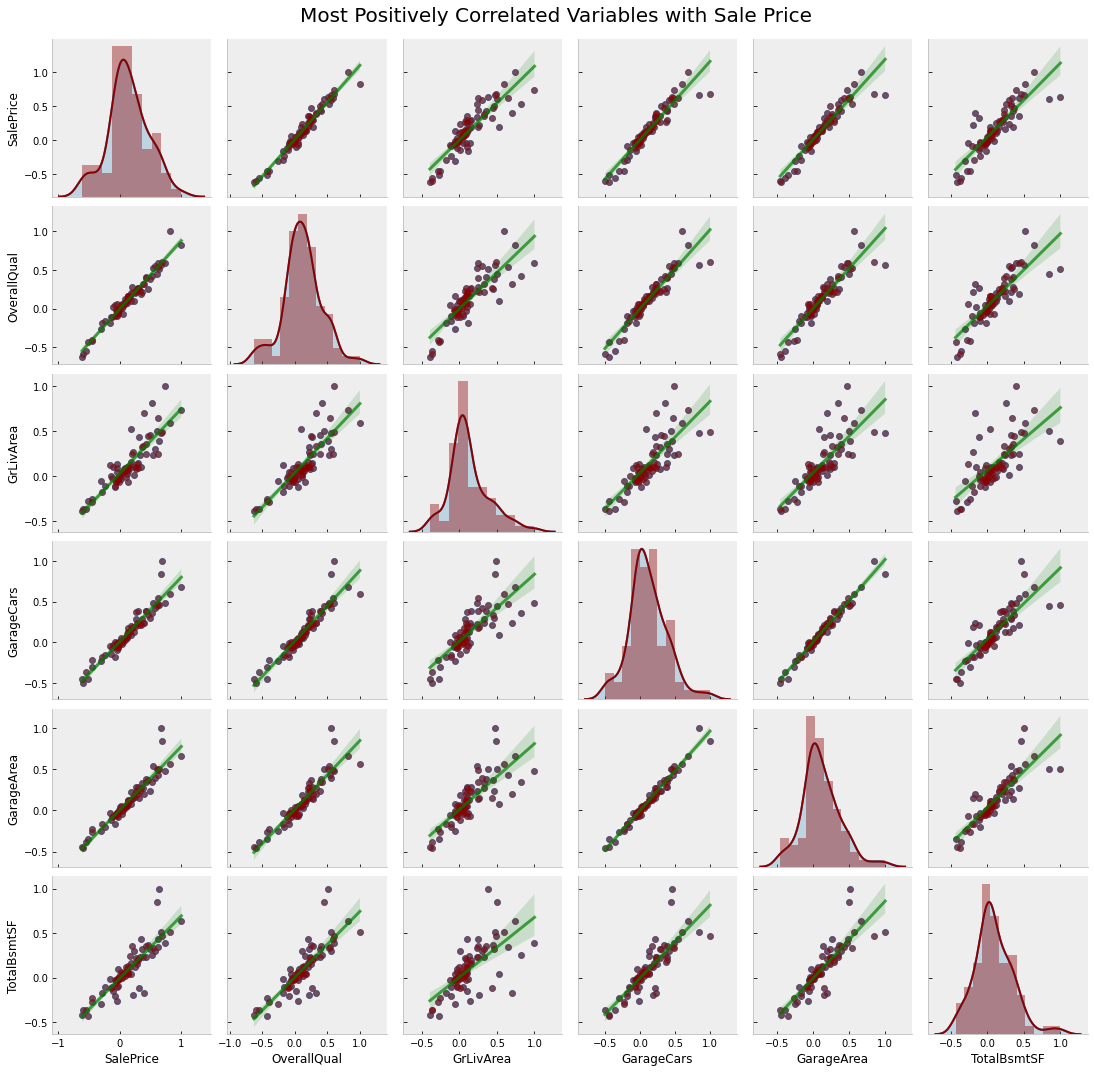

In [38]:
corr_positive = df_corr.loc[:, ['SalePrice', 
                                'OverallQual', 
                                'GrLivArea', 
                                'GarageCars', 
                                'GarageArea', 
                                'TotalBsmtSF']]

g = sns.pairplot(corr_positive, 
                 kind = 'reg', 
                 diag_kind = 'kde', 
                 plot_kws = {'line_kws':{'color':'green', 'alpha': 0.7}}
                ) 
g = g.map_diag(sns.distplot, color = 'darkred')
g = g.map_offdiag(plt.scatter, alpha = 0.5, color = 'darkred')

g.fig.suptitle('Most Positively Correlated Variables with Sale Price', fontsize = 20)
plt.subplots_adjust(top = 0.95)

Let's also create a scatter plot matrix of negatively correlated variables (top 5) with SalePrice:

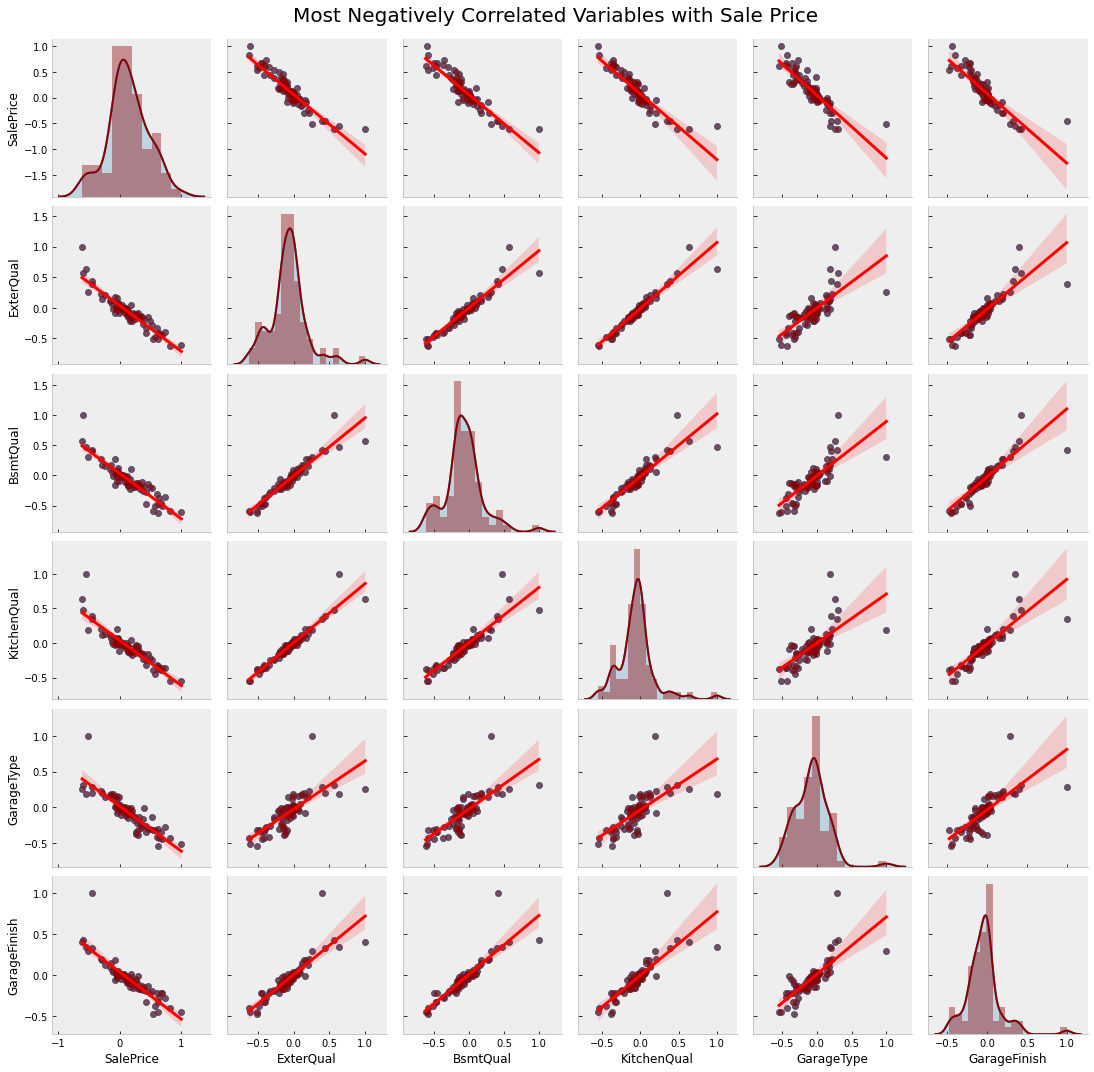

In [39]:
corr_neg = df_corr.loc[:, ['SalePrice', 
                           'ExterQual', 
                           'BsmtQual', 
                           'KitchenQual', 
                           'GarageType', 
                           'GarageFinish']]

g = sns.pairplot(corr_neg, 
                 kind = 'reg', 
                 diag_kind = 'kde', 
                 plot_kws = {'line_kws':{'color':'red'}}
                )
g = g.map_diag(sns.distplot, color = 'darkred')
g = g.map_offdiag(plt.scatter, alpha = 0.5, color = 'darkred')

g.fig.suptitle('Most Negatively Correlated Variables with Sale Price', fontsize = 20)
plt.subplots_adjust(top = 0.95)

**Numerical and Numerical Variable**.

Among these 20 variables, GrLivArea, YearBuilt, GarageArea, TotalBsmtSF, 1stFlrSF, YearRemodAdd, GarageYrBlt are continuous numerical variables. Hence we would investigate how these numerical continuous variables are correlated with our dependent variable SalePrice with the help of regression plot:

In [40]:
# Plot regression plot to see how SalePrice is correlated with numerical variables

corr_num = df_merged.loc[:, ['GrLivArea', 
                             'YearBuilt', 
                             'GarageArea', 
                             'TotalBsmtSF', 
                             '1stFlrSF', 
                             'YearRemodAdd', 
                             'GarageYrBlt']]
corr_num = corr_num.iloc[0:1456, :]

for i in corr_num.columns:
    x = corr_num[i]
    y = y_train
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x + intercept

    # Creating the dataset, and generating the plot
    trace0 = go.Scatter(
                  x = x,
                  y = y,
                  mode = 'markers',
                  marker = dict(color = 'red'),
                  name ='Data'
                  )
    
    # Creating regression line
    trace1 = go.Scatter(
                  x = x,
                  y = line,
                  mode='lines',
                  marker = dict(color = 'green'),
                  name='Fit'
                  )

    # Layout for regression plot
    title = '{} vs SalePrice (r: {:0.4f},   p: {})'.format(corr_num[i].name, r_value, p_value)
    layout = go.Layout(
                    title = title, 
                    yaxis = dict(title = 'SalePrice')
                )

    data = [trace0, trace1]
    fig = go.Figure(data = data, layout = layout)
    iplot(fig)

**Categorical and Numerical Variable**.

A boxplot between our numerical and categorical variables helps to reveal if the distribution of numerical variable is distinct in different classes of nominal variables. More specifically, how SalePrice (strongly or weakly) is associated with these categorical variables. Among the 20 variables are categorical variables that are highly correlated (either positively or negatively) with SalePrice.

In [41]:
# Create boxplots to see the association between categorical and target variables

corr_cat = df_merged.loc[:, ['OverallQual', 
                             'GarageCars', 
                             'FullBath', 
                             'ExterQual', 
                             'BsmtQual', 
                             'KitchenQual', 
                             'GarageType', 
                             'GarageFinish', 
                             'HeatingQC', 
                             'BsmtExposure', 
                             'LotShape', 
                             'MSZoning', 
                             'KitchenAbvGr']]
corr_cat = corr_cat.iloc[0:1456, :]

for i in corr_cat.columns:
    trace = go.Box(x = corr_cat[i], y = y_train, marker = dict (color = 'magenta'))
    data = [trace]
    layout = go.Layout(title = '{} vs SalePrice'.format(i), 
                       yaxis = dict(title = 'SalePrice'))
    
    fig = go.Figure(data = data, 
                    layout = layout)
    iplot(fig)

Since thse variables are highly associated with SalePrice, mean SalePrice should be different across the classes (groups) of these categorical variables. We can visualize this pattern using pivot table:

In [42]:
# Create pivot table to see if mean SalePrice varries across groups of categorical variables

pivot_df = pd.concat([corr_cat, y_train], axis = 1)
for i in corr_cat.columns:
    pivot_table = pivot_df.pivot_table(index = i, 
                                       values = 'SalePrice', 
                                       aggfunc = np.mean)
    
    bar_plot(pivot_table.index, 
             pivot_table.SalePrice, 
             '{} vs Mean SalePrice'.format(i), 
             'Mean SalePrice', 
             'Rainbow')

Mean SalePrice is distinct across the groups of our different categorical variables and hence they have high correlation with SalePrice.

---

### Feature Engineering

We would create a new feature named TotalSF combining TotalBsmtSF, 1stFlrSF, and 2ndFlrSF.

In [43]:
# Create Feature TotalSF

df_merged_num['TotalSF'] = df_merged_num['TotalBsmtSF'] + \
                            df_merged_num['1stFlrSF'] + \
                            df_merged_num['2ndFlrSF']

Two methods are usually well known for rescaling data, i.e., normalization and standarization. Normalization scales all numeric variables in the range [0,1]. So outliers might be lost. On the other hand, standarization transforms data to have zero mean and unit variance.

Feature scaling helps gradient descent converge faster, thus reducing training time. Its not necessary to standarize the target variable. However, due to the presence of outliers, we would use sklearn's RobustScaler since it is not affected by outliers.

In [44]:
from sklearn.preprocessing import RobustScaler

In [45]:
# Initialize robust scaler object
robust_scl = RobustScaler()

# Fit scaler object on train data
robust_scl.fit(df_merged_num)

# Apply scaler object to both train and test data
df_merged_num_scaled = robust_scl.transform(df_merged_num)

In [46]:
# Retrive column names

df_merged_num_scaled = pd.DataFrame(data = df_merged_num_scaled, 
                                    columns = df_merged_num.columns, 
                                    index = df_merged_num.index)

We have to encode categorical variables for our machine learning algorithms to interpret them. We would use label encoding and then one hot encoding.

We would like to encode some categorical (ordinal) variables to preserve their ordinality. If we use sklearn's label encoder, it will randomly encode these ordinal variables and therefore ordinality would be lost. To overcome this, we will use pandas replace method to manually encode orninal variables. Variables like LotShape, LandContour, Utilities, and others have inherent orders. 

Let's encode them:

In [47]:
# Let's extract categorical variables and convert them into category
df_merged_cat = df_merged.select_dtypes(include = ['object']).astype('category')

# Let's begin the tedious process of label encoding
df_merged_cat.LotShape.replace(to_replace = ['IR3', 'IR2', 'IR1', 'Reg'], 
                               value = [0, 1, 2, 3], 
                               inplace = True)
df_merged_cat.LandContour.replace(to_replace = ['Low', 'Bnk', 'HLS', 'Lvl'], 
                                  value = [0, 1, 2, 3], 
                                  inplace = True)
df_merged_cat.Utilities.replace(to_replace = ['NoSeWa', 'AllPub'], 
                                value = [0, 1], 
                                inplace = True)
df_merged_cat.LandSlope.replace(to_replace = ['Sev', 'Mod', 'Gtl'], 
                                value = [0, 1, 2], 
                                inplace = True)
df_merged_cat.ExterQual.replace(to_replace = ['Fa', 'TA', 'Gd', 'Ex'], 
                                value = [0, 1, 2, 3], 
                                inplace = True)
df_merged_cat.ExterCond.replace(to_replace = ['Po', 'Fa', 'TA', 'Gd', 'Ex'], 
                                value = [0, 1, 2, 3, 4], 
                                inplace = True)
df_merged_cat.BsmtQual.replace(to_replace = ['None', 'Fa', 'TA', 'Gd', 'Ex'], 
                               value = [0, 1, 2, 3, 4], 
                               inplace = True)
df_merged_cat.BsmtCond.replace(to_replace = ['None', 'Po', 'Fa', 'TA', 'Gd'], 
                               value = [0, 1, 2, 3, 4], 
                               inplace = True)
df_merged_cat.BsmtExposure.replace(to_replace = ['None', 'No', 'Mn', 'Av', 'Gd'], 
                                   value = [0, 1, 2, 3, 4], 
                                   inplace = True)
df_merged_cat.BsmtFinType1.replace(to_replace = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], 
                                   value = [0, 1, 2, 3, 4, 5, 6], 
                                   inplace = True)
df_merged_cat.BsmtFinType2.replace(to_replace = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], 
                                   value = [0, 1, 2, 3, 4, 5, 6], 
                                   inplace = True)
df_merged_cat.HeatingQC.replace(to_replace = ['Po', 'Fa', 'TA', 'Gd', 'Ex'], 
                                value = [0, 1, 2, 3, 4], 
                                inplace = True)
df_merged_cat.Electrical.replace(to_replace = ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'], 
                                 value = [0, 1, 2, 3, 4], 
                                 inplace = True)
df_merged_cat.KitchenQual.replace(to_replace = ['Fa', 'TA', 'Gd', 'Ex'], 
                                  value = [0, 1, 2, 3], 
                                  inplace = True)
df_merged_cat.Functional.replace(to_replace = ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], 
                                 value = [0, 1, 2, 3, 4, 5, 6], 
                                 inplace = True)
df_merged_cat.FireplaceQu.replace(to_replace =  ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], 
                                  value = [0, 1, 2, 3, 4, 5], 
                                  inplace = True)
df_merged_cat.GarageFinish.replace(to_replace =  ['None', 'Unf', 'RFn', 'Fin'], 
                                   value = [0, 1, 2, 3], 
                                   inplace = True)
df_merged_cat.GarageQual.replace(to_replace =  ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], 
                                 value = [0, 1, 2, 3, 4, 5], 
                                 inplace = True)
df_merged_cat.GarageCond.replace(to_replace =  ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], 
                                 value = [0, 1, 2, 3, 4, 5], 
                                 inplace = True)
df_merged_cat.PavedDrive.replace(to_replace =  ['N', 'P', 'Y'], 
                                 value = [0, 1, 2], 
                                 inplace = True)
df_merged_cat.PoolQC.replace(to_replace =  ['None', 'Fa', 'Gd', 'Ex'], 
                             value = [0, 1, 2, 3], 
                             inplace = True)
df_merged_cat.Fence.replace(to_replace =  ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'], 
                            value = [0, 1, 2, 3, 4], 
                            inplace = True)

All the encodeded variables have int64 dtype except OverallQual and OverallCond. So convert them back into int64:

In [48]:
df_merged_cat.loc[:, ['OverallQual', 'OverallCond']] = df_merged_cat. \
                                                        loc[:, ['OverallQual', 'OverallCond']]. \
                                                        astype('int64')

Extract label encoded variables:

In [49]:
df_merged_label_encoded = df_merged_cat.select_dtypes(include = ['int64'])


<br>Categorical variables without any inherent order will be converted into numerical for our model using pandas get_dummies method. So basically variables in df_merged_cat data frame with category dtypes are nominal variables for one hot encoding.

In [50]:
# Extract the nominal variables for one hot encoding

df_merged_one_hot = df_merged_cat.select_dtypes(include = ['category'])
df_merged_one_hot = pd.get_dummies(df_merged_one_hot)

In [51]:
# Let's concate one hot encoded and label encoded variables together

df_merged_encoded = pd.concat([df_merged_one_hot, df_merged_label_encoded], axis = 1)

In [52]:
# Finally join processed categorical and numerical variables

df_merged_processed = pd.concat([df_merged_num_scaled, df_merged_encoded], axis = 1)

In [53]:
# Retrive train and test data for modelling
df_train_final = df_merged_processed.iloc[0:1456, :]
df_test_final = df_merged_processed.iloc[1456:, :]

# And we have our target variable as y_train
y_train = y_train

Let's look at our final train and test data for modelling:

In [54]:
bold('**Updated train data for modelling:**')
display(df_train_final.head())

bold('**Updated test data for modelling:**')
display(df_test_final.head())

**Updated train data for modelling:**

1stFlrSF  2ndFlrSF  3SsnPorch  BedroomAbvGr  BsmtFinSF1  BsmtFinSF2  \
0 -0.512612  1.029526        0.0           0.0    0.098563         0.0   
1  0.336748  0.000000        0.0           0.0    0.147903         0.0   
2 -0.354872  1.031651        0.0           0.0    0.042059         0.0   
3 -0.259481  1.010961        0.0           0.0   -0.080474         0.0   
4  0.123838  1.061435        0.0           1.0    0.087214         0.0   

   BsmtFullBath  BsmtHalfBath  BsmtUnfSF  EnclosedPorch  ...  HeatingQC  \
0           1.0      0.000000  -0.875494       0.000000  ...          4   
1           0.0      0.693147  -0.383868       0.000000  ...          4   
2           1.0      0.000000  -0.056594       0.000000  ...          4   
3           1.0      0.000000   0.112186       5.609472  ...          3   
4           1.0      0.000000   0.037131       0.000000  ...          4   

   KitchenQual  LandContour  LandSlope  LotShape  OverallCond  OverallQual  \
0            2            3          2         3            5            7   
1            1            3          2         3            8            6   
2            2            3          2         2            5            7   
3            2            3          2         2            5            7   
4            2            3          2         2            5            8   

   PavedDrive  PoolQC  Utilities  
0           2       0          1  
1           2       0          1  
2           2       0          1  
3           2       0          1  
4           2       0          1  

[5 rows x 248 columns]

**Updated test data for modelling:**

1stFlrSF  2ndFlrSF  3SsnPorch  BedroomAbvGr  BsmtFinSF1  BsmtFinSF2  \
0 -0.412702  0.000000        0.0          -1.0    0.036350    4.976734   
1  0.449956  0.000000        0.0           0.0    0.139138    0.000000   
2 -0.335930  0.999458        0.0           0.0    0.115772    0.000000   
3 -0.340650  0.994378        0.0           0.0    0.074444    0.000000   
4  0.367741  0.000000        0.0          -1.0   -0.050756    0.000000   

   BsmtFullBath  BsmtHalfBath  BsmtUnfSF  EnclosedPorch  ...  HeatingQC  \
0           0.0           0.0  -0.422852            0.0  ...          2   
1           0.0           0.0  -0.108087            0.0  ...          2   
2           0.0           0.0  -0.945170            0.0  ...          3   
3           0.0           0.0  -0.282219            0.0  ...          4   
4           0.0           0.0   0.601464            0.0  ...          4   

   KitchenQual  LandContour  LandSlope  LotShape  OverallCond  OverallQual  \
0            1            3          2         3            6            5   
1            2            3          2         2            6            6   
2            1            3          2         2            5            5   
3            2            3          2         2            6            6   
4            2            2          2         2            5            8   

   PavedDrive  PoolQC  Utilities  
0           2       0          1  
1           2       0          1  
2           2       0          1  
3           2       0          1  
4           2       0          1  

[5 rows x 248 columns]

In [55]:
bold('**Shape of our df_train_final and df_test_final data:**')
display(df_train_final.shape, df_test_final.shape)

**Shape of our df_train_final and df_test_final data:**

(1456, 248)

(1459, 248)

Было: 
<br>(1460, 81)
<br>(1459, 80)

---

### Model Building & Evaluation

In [57]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

With all the preprocessings done and dusted, we're ready to train our regression models with the processed data.

In [56]:
# A final look at our data

bold('**Data Dimension for Model Building:**')

print('Input matrix dimension:', df_train_final.shape)
print('Output vector dimension:',y_train.shape)
print('Test data dimension:', df_test_final.shape)

**Data Dimension for Model Building:**

Input matrix dimension: (1456, 248)
Output vector dimension: (1456,)
Test data dimension: (1459, 248)


We are interested in the following 14 regression models.
<br>All initialized with default parameters except random_state and n_jobs:

In [58]:
seed = 43

linear = LinearRegression(n_jobs = -1)
lasso = Lasso(random_state = seed)
ridge = Ridge(random_state = seed)
kr = KernelRidge()
elnt = ElasticNet(random_state = seed)
dt = DecisionTreeRegressor(random_state = seed)
svm = SVR()
knn = KNeighborsRegressor(n_jobs = -1)
rf =  RandomForestRegressor(n_jobs = -1, random_state = seed)
et = ExtraTreesRegressor(n_jobs = -1, random_state = seed)
ab = AdaBoostRegressor(random_state = seed)
gb = GradientBoostingRegressor(random_state = seed)
xgb = XGBRegressor(random_state = seed, n_jobs = -1)
lgb = LGBMRegressor(random_state = seed, n_jobs = -1)

In [59]:
def train_r2(model):
    model.fit(df_train_final, y_train)
    
    return model.score(df_train_final, y_train)

Calculate and plot the training accuracy:

In [60]:
models = [linear, lasso, ridge, kr, elnt, dt, svm, knn, rf, et, ab, gb, xgb, lgb]

training_score = []
for model in models:
    training_score.append(train_r2(model))

In [61]:
train_score = pd.DataFrame(data = training_score, 
                           columns = ['Training_R2'])
train_score.index = ['LR', 'LSO', 'RIDGE', 'KR', 'ELNT', 'DT', 'SVM', 'KNN', 'RF', 'ET', 'AB', 'GB', 'XGB', 'LGB']
train_score = (train_score*100).round(4)

scatter_plot(train_score.index, 
             train_score['Training_R2'], 
             'Training Score (R_Squared)', 
             'Models',
             '% Training Score', 
             30, 
             'Rainbow')

Being a regression problem, score method returns r_squared(coefficients of determination) and hence bigger is better. Looks like DT and ET have exactly r2_score of 100%. Usually higher r2_score is better but r2_score very close to 1 might indicate overfitting. But train accuracy of a model is not enough to tell if a model can be able to generalize the unseen data or not. Because training data is something our model has been trained with, i.e., data our model has already seen it. 

We all know that, the purpose of building a machine learning model is to generalize the unseen data, i.e., data our model has not yet seen. Hence we can't use training accuracy for our model evaluation rather we must know how our model will perform on the data our model is yet to see.

So basically, to evaluate a model's performance, we need some data (input) for which we know the ground truth(label). 
<br>One thing we can do is to split the train set in two groups, usually in 80:20 ratio:

In [62]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [63]:
def train_test_split_score(model):
    X_train, X_test, Y_train, Y_test = train_test_split(df_train_final, 
                                                        y_train, 
                                                        test_size = 0.3, 
                                                        random_state = seed)
    
    model.fit(X_train, Y_train)
    prediction = model.predict(X_test)
    
    mse = mean_squared_error(prediction, Y_test)
    rmse = np.sqrt(mse)
    
    return rmse

Calculate train_test_split score of differnt models and plot them:

In [64]:
models = [lasso, ridge, kr, elnt, dt, svm, knn, rf, et, ab, gb, xgb, lgb]

train_test_split_rmse = []
for model in models:
    train_test_split_rmse.append(train_test_split_score(model))

In [65]:
train_test_score = pd.DataFrame(data = train_test_split_rmse, 
                                columns = ['Train_Test_RMSE'])
train_test_score.index = ['LSO', 'RIDGE', 'KR', 'ELNT', 'DT', 'SVM', 'KNN', 'RF', 'ET', 'AB', 'GB', 'XGB', 'LGB']
train_test_score = train_test_score.round(5)

x = train_test_score.index
y = train_test_score['Train_Test_RMSE']

title = "Models' Test Score (RMSE) on Holdout(30%) Set"
scatter_plot(x, 
             y, 
             title, 
             'Models',
             'RMSE', 
             30, 
             'RdBu')

Being root mean squared error, smaller is better. Looks like, SVM is the best regression model followed by Ridge, GB and XGB. Unfortunately, LR can't find any linear pattern, hence it performs worst and hence discarded.

However, train_test split has its drawbacks. Because this approach introduces bias as we are not using all of our observations for testing and also we're reducing the train data size. To overcome this we can use a technique called cross validation where all the data is used for training and testing periodically. Thus we may reduce the bias introduced by train_test_split.

From different cross validation methods, we would use k-fold cross validation:

In [66]:
from sklearn.model_selection import cross_val_score

In [67]:
def cross_validate(model):
    neg_x_val_score = cross_val_score(model, 
                                      df_train_final, 
                                      y_train, 
                                      cv = 10, 
                                      n_jobs = -1, 
                                      scoring = 'neg_mean_squared_error')
    x_val_score = np.round(np.sqrt(-1*neg_x_val_score), 5)
    
    return x_val_score.mean()

Calculate cross validation score of differnt models and plot them:

In [68]:
models = [lasso, ridge, kr, elnt, dt, svm, knn, rf, et, ab, gb, xgb, lgb]

cross_val_scores = []
for model in models:
    cross_val_scores.append(cross_validate(model))

In [69]:
x_val_score = pd.DataFrame(data = cross_val_scores, 
                           columns = ['Cross Validation Scores (RMSE)'])
x_val_score.index = ['LSO', 'RIDGE', 'KR', 'ELNT', 'DT', 'SVM', 'KNN', 'RF', 'ET', 'AB', 'GB', 'XGB', 'LGB']
x_val_score = x_val_score.round(5)

x = x_val_score.index
y = x_val_score['Cross Validation Scores (RMSE)']

title = "Models' 10-fold Cross Validation Scores (RMSE)"
scatter_plot(x, 
             y, 
             title, 
             'Models',
             'RMSE', 
             30, 
             'Viridis')

Looks like Ridge has managed to beat SVM as the best regression model on 10-fold cross validation. And rmse of GB, XGB, and LGB have also dropped from previous holdout set's rmse.

// Now looks like we would prefer to test in more details Ridge, SVM, GB.

Now let's add Grid Search to all the models with the hopes of optimizing their hyperparameters and thus improving their accuracy. Are the default model parameters the best bet? Let's find out:

In [71]:
from sklearn.model_selection import GridSearchCV

In [72]:
# Hyperparameters should be tuned for all the models you try because only then 
# you will be able to tell what is the best you can get out of that particular model

def grid_search_cv(model, params):
    global best_params, best_score

    grid_search = GridSearchCV(estimator = model, 
                               param_grid = params, 
                               cv = 10, 
                               verbose = 1,
                               scoring = 'neg_mean_squared_error', 
                               n_jobs = -1)
    grid_search.fit(df_train_final, y_train)
    
    best_params = grid_search.best_params_ 
    best_score = np.sqrt(-1*(np.round(grid_search.best_score_, 5)))
    
    return best_params, best_score

Optimize Lasso:

In [73]:
alpha = [0.0001, 0.0002, 0.00025, 0.0003, 0.00031, 0.00032, 0.00033, 0.00034, 0.00035, 0.00036, 0.00037, 0.00038, 
         0.0004, 0.00045, 0.0005, 0.00055, 0.0006, 0.0008,  0.001, 0.002, 0.005, 0.007, 0.008, 0.01]

lasso_params = {'alpha': alpha,
               'random_state':[seed]}

grid_search_cv(lasso, lasso_params)
lasso_best_params, lasso_best_score = best_params, best_score
print('Lasso best params:{} & best_score:{:0.5f}' .format(lasso_best_params, lasso_best_score))

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s


Lasso best params:{'alpha': 0.00033, 'random_state': 43} & best_score:0.10932


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    7.3s finished


Optimize Ridge:

In [74]:
ridge_params = {'alpha':[ 9, 9.2, 9.4, 9.5, 9.52, 9.54, 9.56, 9.58, 9.6, 9.62, 9.64, 9.66, 9.68, 9.7,  9.8],
               'random_state':[seed]}

grid_search_cv(ridge, ridge_params)
ridge_best_params, ridge_best_score = best_params, best_score
print('Ridge best params:{} & best_score:{:0.5f}' .format(ridge_best_params, ridge_best_score))

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Ridge best params:{'alpha': 9.64, 'random_state': 43} & best_score:0.11077


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished


Optimize Kernel Ridge:

In [75]:
kernel_params = {'alpha':[0.27, 0.28, 0.29, 0.3],
                'kernel':['polynomial', 'linear'], 
                'degree':[2, 3],
                'coef0':[3.5, 4, 4.2]}

grid_search_cv(kr, kernel_params)
kernel_best_params, kernel_best_score = best_params, best_score
print('Kernel Ridge best params:{} & best_score:{:0.5f}' .format(kernel_best_params, kernel_best_score))

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s


Kernel Ridge best params:{'alpha': 0.28, 'coef0': 4, 'degree': 2, 'kernel': 'polynomial'} & best_score:0.10849


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   25.1s finished


Optimize Elastic Net:

In [76]:
elastic_params = {'alpha': [ 0.0003, 0.00035, 0.00045, 0.0005], 
                 'l1_ratio': [0.80, 0.85, 0.9, 0.95],
                 'random_state':[seed]}

grid_search_cv(elnt, elastic_params)
elastic_best_params, elastic_best_score = best_params, best_score
print('Elastic Net best params:{} & best_score:{:0.5f}' .format(elastic_best_params, elastic_best_score))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.4s


Elastic Net best params:{'alpha': 0.00035, 'l1_ratio': 0.95, 'random_state': 43} & best_score:0.10932


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.5s finished


Optimize Support Vector Machine:

In [77]:
svm_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
              'C': [4, 5], 
              'gamma':[0.0001, 0.001]}

grid_search_cv(svm, svm_params)
svm_best_params, svm_best_score = best_params, best_score
print('SVM best params:{} & best_score:{:0.5f}' .format(svm_best_params, svm_best_score))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  5.6min finished


SVM best params:{'C': 5, 'gamma': 0.001, 'kernel': 'rbf'} & best_score:0.11162


Optimize XGB, GB, and LGB:

In [78]:
# Hyperparameters of gb
gb_opt = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05,
                                   max_depth = 4, max_features = 'sqrt',
                                   min_samples_leaf = 15, min_samples_split = 10, 
                                   loss = 'huber', random_state = seed)

# Hyperparameters of xgb
xgb_opt = XGBRegressor(colsample_bytree = 0.4603, gamma = 0.0468, 
                       learning_rate = 0.04, max_depth = 3, 
                       min_child_weight = 1.7817, n_estimators = 2500,
                       reg_alpha = 0.4640, reg_lambda = 0.8571,
                       subsample = 0.5213, silent = 1,
                       nthread = -1, random_state = 7)

# Hyperparameters of lgb
lgb_opt = LGBMRegressor(objective = 'regression', num_leaves = 5,
                        learning_rate=0.05, n_estimators = 660,
                        max_bin = 55, bagging_fraction = 0.8,
                        bagging_freq = 5, feature_fraction = 0.2319,
                        feature_fraction_seed = 9, bagging_seed = 9,
                        min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11)

# We can assume these 3 model best score is equal to cross validation scores.
# Thought it might not be precise, but I will take it'''
xgb_best_score = cross_validate(xgb_opt)
gb_best_score = cross_validate(gb_opt)
lgb_best_score = cross_validate(lgb_opt)

Let's plot the models' rmse after optimizationЖ

In [79]:
optimized_scores = pd.DataFrame({'Optimized Scores':np.round([lasso_best_score, 
                                                              ridge_best_score, 
                                                              kernel_best_score, 
                                                              elastic_best_score, 
                                                              svm_best_score, 
                                                              xgb_best_score, 
                                                              gb_best_score, 
                                                              lgb_best_score], 
                                                             5)})
optimized_scores.index = ['Lasso', 'Ridge', 'Kernel_ridge', 'E_net', 'SVM', 'XGB', 'GB', 'LGB']
optimized_scores.sort_values(by = 'Optimized Scores')

scatter_plot(optimized_scores.index, 
             optimized_scores['Optimized Scores'], 
             "Models' Scores after Optimization", 
             'Models','Optimized Scores', 
             40, 
             'Rainbow')

Looks like kernel ridge is the best model after optimization. Lasso and elastic net score exactly identical. LGB and GB scores the worst among five models after optimization.

Now we would like to retrain our models using the best parameters responsible for best rmse after optimization. Then we would predict on test data to see how different models perform on leaderboard.

In [80]:
lasso_opt = Lasso(**lasso_best_params)
ridge_opt = Ridge(**ridge_best_params)
kernel_ridge_opt = KernelRidge(**kernel_best_params)
elastic_net_opt = ElasticNet(**elastic_best_params)
svm_opt = SVR(**svm_best_params)
xgb_opt = xgb_opt
gb_opt = gb_opt
lgb_opt = lgb_opt

In [81]:
def predict_with_optimized_models(model):
    model.fit(df_train_final, y_train)
    y_pred = np.expm1(model.predict(df_test_final))
    
    submission = pd.DataFrame()
    submission['Id']= test.Id
    submission['SalePrice'] = y_pred
    
    return submission

In [82]:
# 8 csv files to make submission

predict_with_optimized_models(lasso_opt)
predict_with_optimized_models(ridge_opt)
predict_with_optimized_models(kernel_ridge_opt).to_csv('kernel_ridge_optimized.csv', index = False)
predict_with_optimized_models(elastic_net_opt)
predict_with_optimized_models(svm_opt)
predict_with_optimized_models(xgb_opt)
predict_with_optimized_models(gb_opt)
predict_with_optimized_models(lgb_opt)

[20:42:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Plot the leaderboard results:

In [83]:
scores_on_submission = pd.DataFrame({'Leaderboard_score':[0.12193, 0.12005, 0.11786, 
                                                          0.12190, 0.12057, 0.12764, 
                                                          0.12234, 0.12188]})
scores_on_submission.index = ['Opt_lasso', 'Opt_ridge', 'Opt_kernel_ridge', 
                              'Opt_elastic_net', 'Opt_svm', 'Opt_xgb', 
                              'Opt_gb', 'Opt_lgb']
scores_on_submission.sort_values(by = 'Leaderboard_score')

scatter_plot(scores_on_submission.index, 
             scores_on_submission['Leaderboard_score'], 
             'Leaderboard Scores after Optimization',
             'Models', 
             'Optimized Scores', 
             40, 
             'Greens')

Its kernel ridge that scores best (0.11786) on leaderboard after optimization, followed by ridge and svm. The xgb scores worst among the 8 models.

#### Feature Importance

Do all these 8 models give equal importance to every features? Of course not! We would try to visualize feature importance given by every model except svm. Since svm is not using linear kernel, its feature importance can not be derived.

In [86]:
# Function to plot scatter plot of feature importance

def plot_feature_importance(model, title):
    model.fit(df_train_final, y_train)
    coef = pd.DataFrame({'Feature':df_train_final.columns,'Importance':np.transpose(model.coef_)})
    coef = coef.set_index('Feature')
    
    trace = go.Scatter(x = coef.index, y = coef.Importance, mode = 'markers',
            marker = dict(color = np.random.randn(500), size = 20, showscale = True, colorscale = 'Hot'))
    layout = go.Layout(hovermode = 'closest', title = title, yaxis = dict(title = 'Importance'))
    fig = go.Figure(data = [trace], layout = layout)
    
    iplot(fig)

In [85]:
plot_feature_importance(lasso_opt, 'Lasso Feature Importance')
plot_feature_importance(ridge_opt, 'Ridge Feature Importance')
plot_feature_importance(elastic_net_opt, 'ElasticNet Feature Importance')

Looks like GrLivArea is the the most positively correlated factor for SalePrice while MSZoning_C(all) is the most inversely correlated factors for SalePrice for all the three models.

Now plot feature importance given by xgb, gb, and lgb:

In [88]:
def plot_featute_importance(model, title):
    importance = pd.DataFrame({'Features': df_train_final.columns, 'Importance': model.feature_importances_})
    importance = importance.set_index('Features')
    
    trace = go.Scatter(x = importance.index, y = importance.Importance, mode = 'markers',
                      marker = dict(color = np.random.randn(500), size = 20, showscale = True, colorscale = 'Rainbow'))
    layout = go.Layout(hovermode = 'closest', title = title, yaxis = dict(title = 'Importance'))
    fig = go.Figure(data = [trace], layout = layout)
    
    iplot(fig)

In [89]:
plot_featute_importance(xgb_opt, 'XGB Feature Importance')
plot_featute_importance(gb_opt, 'GB Feature Importance')
plot_featute_importance(lgb_opt, 'LGB Feature Importance')

GrLivArea and LotArea seem to be most importance features given by xgb, gb, and lgb.

Plot learning curves to see the bias-variance tradeoff of our models:

In [91]:
from sklearn.model_selection import learning_curve

In [92]:
def plot_learning_curve(model):
    
    # df_train_final is training matrix and y_train is target matrix.
    # Create CV training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(model, 
                                                            df_train_final, 
                                                            y_train, 
                                                            train_sizes = np.linspace(0.01, 1.0, 20), 
                                                            cv = 10, 
                                                            scoring = 'neg_mean_squared_error', 
                                                            n_jobs = -1, 
                                                            random_state = seed)
    
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)  
    
    # Draw lines
    plt.plot(train_sizes, train_mean, 'o-', color = 'red',  label = 'Training score')
    plt.plot(train_sizes, test_mean, 'o-', color = 'green', label = 'Cross-validation score')
    
    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha = 0.1, color = 'r') # Alpha controls band transparency.
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha = 0.1, color = 'g')
    
    # Create plot
    font_size = 12
    plt.xlabel('Training Set Size', fontsize = font_size)
    plt.ylabel('Accuracy Score', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.legend(loc = 'best')
    plt.grid()

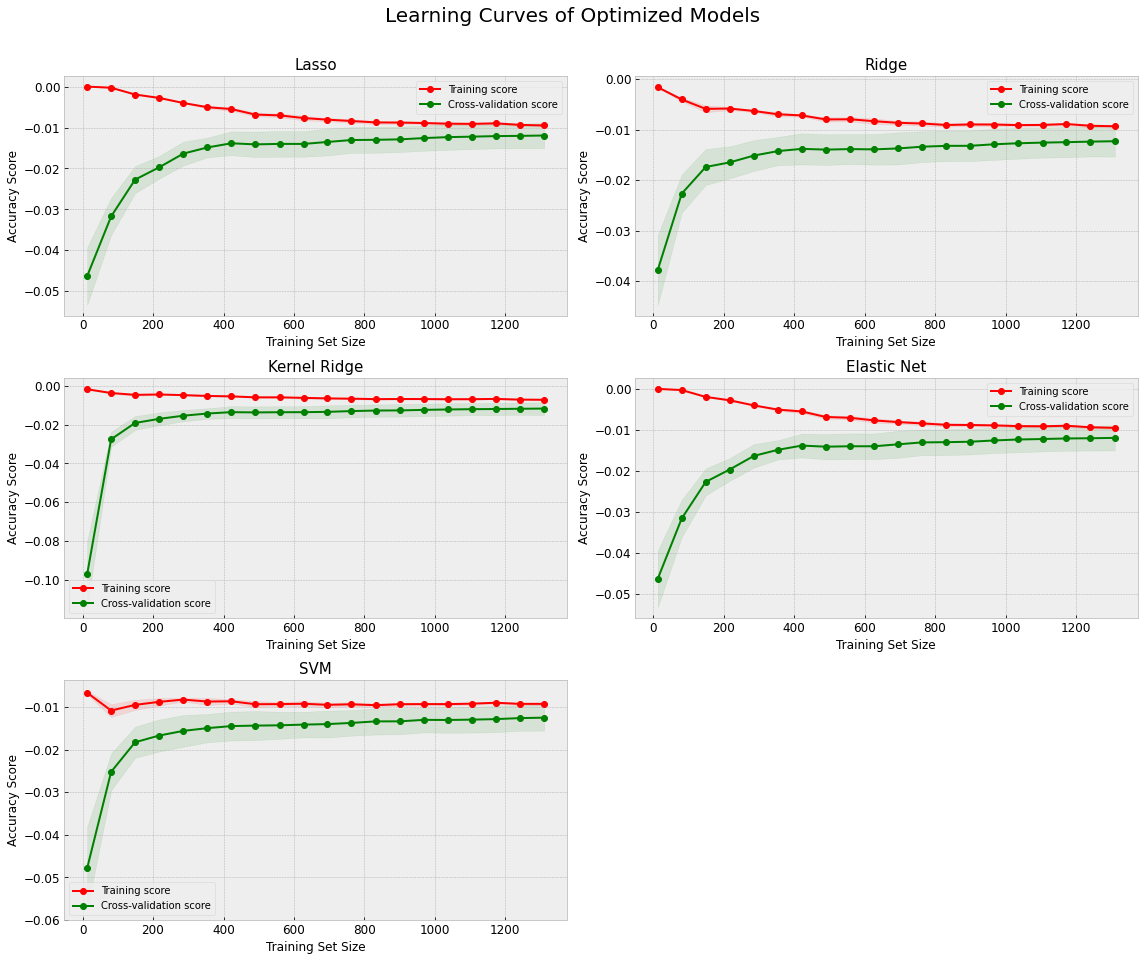

In [93]:
plt.figure(figsize = (16,14))
lc_models = [lasso_opt, ridge_opt, kernel_ridge_opt, elastic_net_opt, svm_opt]
lc_labels = ['Lasso', 'Ridge', 'Kernel Ridge', 'Elastic Net', 'SVM']

for ax, models, labels in zip (range(1,6), lc_models, lc_labels):
    plt.subplot(3,2,ax)
    plot_learning_curve(models)
    plt.title(labels, fontsize = 15)
    
plt.suptitle('Learning Curves of Optimized Models', fontsize = 20)
plt.tight_layout(rect = [0, 0.03, 1, 0.97])

All of the model are doing okay in terms of bias-variance tradeoff except kernel ridge(just a bit of high bias or low variance and hence underfitting). Since training and validation curves haven't yet converged, adding more instances might help for lasso, ridge, elastic net and svm. And for kernel ridge, increasing model's complexity (perhaps adding more features) might help.

---

### Ensemble Beggining

Ensembles combine predictions from different models to generate a final prediction, and the more models we include the better it performs. Better still, because ensembles combine baseline predictions, they perform at least as well as the best baseline model. 

Most of the errors from a model’s learning are from three main factors: variance, noise, and bias. By using ensemble methods, we’re able to increase the stability of the final model and reduce the errors caused by bias, variance, and noise. By combining many models, we’re able to (mostly) reduce the variance, even when they are individually not great, as we won’t suffer from random errors from a single source. 

*To implement an ensemble we need three basic things*:

* A group of base learners that generate predictions.
* A meta learner that learns how to best combine these predictions outputed by base learners.
* And finally a method for splitting the training data between the base learners and the meta learner.

*An ensemble works best if*:

* There is a less correlation in the base models' predictions.
* We increase the number of base learners though it might slow the process down.

*Ensemble methods can be divided into two, i.e.*,

* Simple Ensemble Method 
* Advanced Ensemble Method

Being a regression problem, we would perform averaging method only. Before performing averaging ensemble, we need to investigate the correlations among the base models' predictions so that we can choose the most diverse model that would perform better than correlated models:

In [94]:
base_model_prediction = pd.DataFrame({'LGB':lgb_opt.predict(df_test_final), 
                                      'Lasso':lasso_opt.predict(df_test_final), 
                                      'Ridge':ridge_opt.predict(df_test_final), 
                                      'GB':gb_opt.predict(df_test_final), 
                                      'Kernel Ridge':kernel_ridge_opt.predict(df_test_final),
                                      'Elastic Net':elastic_net_opt.predict(df_test_final), 
                                      'XGB':xgb_opt.predict(df_test_final), 
                                      'SVM':svm_opt.predict(df_test_final)})

bold('**All the Base Model Predictions:**')
display(base_model_prediction.head())

**All the Base Model Predictions:**

LGB      Lasso      Ridge         GB  Kernel Ridge  Elastic Net  \
0  11.714597  11.681803  11.682466  11.702192     11.690983    11.681755   
1  11.964107  11.983817  11.968683  11.952509     12.007951    11.983750   
2  12.142404  12.104024  12.102390  12.157374     12.118397    12.104003   
3  12.172094  12.201175  12.196572  12.155044     12.185863    12.201207   
4  12.176124  12.208492  12.191684  12.094677     12.189228    12.208306   

         XGB        SVM  
0  11.720313  11.698735  
1  11.997543  11.985991  
2  12.133332  12.112720  
3  12.173647  12.196261  
4  12.165203  12.167346

Let's visualize the correlations among the predictions of base models:

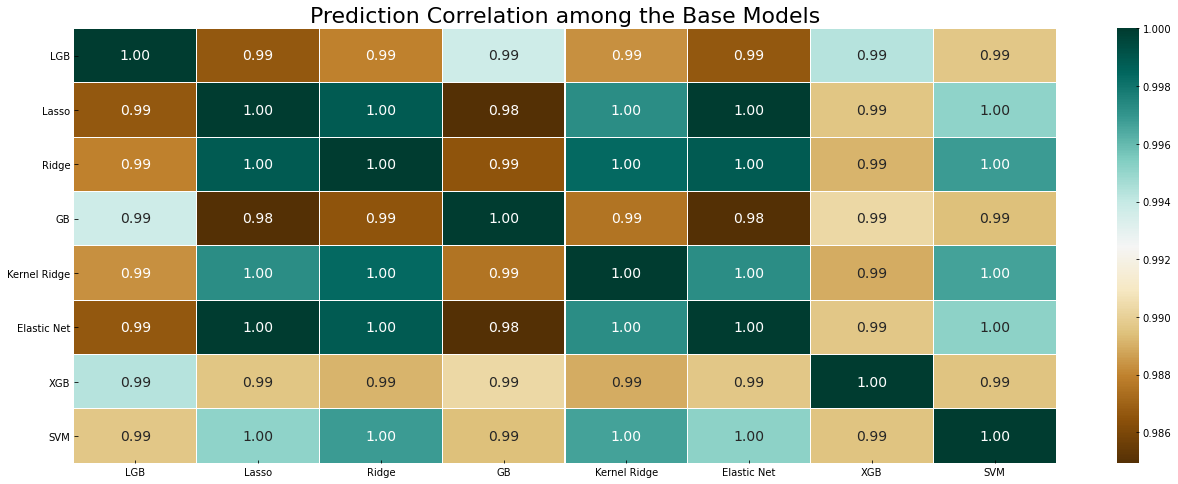

In [95]:
fig, ax = plt.subplots(figsize = (22, 8))
ax.set_title('Prediction Correlation among the Base Models', fontsize = 22)

sns.heatmap(base_model_prediction.corr(), 
            annot = True, cmap ='BrBG', 
            ax = ax, fmt='.2f', 
            linewidths = 0.05, 
            annot_kws = {'size': 14})
plt.show()

Predictions look pretty similar for all the 8 models. We would like to take kernel ridge, svm, lgb, gb, and ridge as the base models for averaging ensemble method.

As I said earlier, the more diverse our base models are, the more superior our ensemble is. We saw GrLivArea is the top priority for all the 6 models in feature importance section. But the second priority for lasso, ridge, and elastic net was YearBuilt while it was LotArea for xgb, gb, and lgb. That's the variation we need for our ensemble to get better at prediction. If we would choose lasso and elastic net, there would be similarity instead of diversity.

In [98]:
y_kernel_ridge = np.expm1(kernel_ridge_opt.predict(df_test_final))
y_svm = np.expm1(svm_opt.predict(df_test_final))
y_lgb = np.expm1(lgb_opt.predict(df_test_final))
y_gb = np.expm1(gb_opt.predict(df_test_final))
y_ridge = np.expm1(ridge_opt.predict(df_test_final))

avg_ensemble = (y_kernel_ridge + y_lgb + y_svm + y_gb + y_ridge) / 5

In [100]:
submission_avg = pd.DataFrame()
submission_avg['Id'] = test.Id
submission_avg['SalePrice'] = avg_ensemble
#submission_avg.to_csv('avrage_ensemble.csv', index = False)

In [104]:
submission_avg.head()

Id      SalePrice
0  1461  120312.114343
1  1462  158899.813029
2  1463  184768.067409
3  1464  195103.729425
4  1465  191843.141160

We have averaged 5 models predictions to make final prediction. One thing to remember is the more diverse our base models are, the more accurate our ensemble will be. The above submission scored 0.11628.

Lets try more sophisticated ensemble method.

**Stacking**: Fitting an ensemble with cross-validation is often referred to as stacking, while the ensemble itself is known as the Super Learner.

In [105]:
from vecstack import stacking
from sklearn.metrics import mean_squared_error

ModuleNotFoundError: No module named 'vecstack'

Initialize base models. We will use the same base models as averaging ensemble:

In [ ]:
base_models = [kernel_ridge_opt, svm_opt, lgb_opt, gb_opt, ridge_opt]

bold('**Performing Stacking...**')
S_train, S_test = stacking(base_models,                # list of base models
                           df_train_final, y_train, df_test_final,   # data
                           regression = True,          # We need regression - set to True)
                                                       
                           mode = 'oof_pred_bag',      # mode: oof for train set, predict test 
                                                       # set in each fold and vote
                           needs_proba = False,        # predict class labels (if you need 
                                                       # probabilities - set to True) 
                           save_dir = None,            # do not save result and log (to save 
                                                       # in current dir - set to '.')
                           metric = mean_squared_error,# metric: callable
                           n_folds = 10,               # number of folds
                           stratified = False,         # stratified split for folds
                           shuffle = True,             # shuffle the data
                           random_state =  seed,       # ensure reproducibility
                           verbose = 1)                # print progress
bold('**Stacking Done...**')

So now we have OOF from base (or 0 level models) models and we can build level 1 model(meta model). We have 5 base models (level 0 models), so we expect to get 5 columns in S_train and S_test. S_train will be our input feature to train our meta learner and then prediction will be made on S_test after we train our meta learner. And this prediction on S_test is actually the prediction for our test set (X_test). 

Before we train our meta learner we can investigate S_train and S_test:

In [ ]:
# Input features for meta learner

bold('**Input Features for Meta Learner:**')
display(S_train[:5])
display(S_train.shape)

In [ ]:
# Test (prediction) set for meta learner

bold('**Test Set for Meta Learner:**')
display(S_test[:5].shape)
display(S_test.shape)

In [ ]:
# Initialize 1st level model that is our meta learner. We will use kernel ridge
super_learner = kernel_ridge_opt 

# Fit meta learner on the output of base learners
print('Fitting Stacking...')
super_learner.fit(S_train, y_train)
print('Done.')

In [ ]:
# Finally predict using super learner
y_pred_super = np.expm1(super_learner.predict(S_test))

# Make submission with super learner
submission_super_learner = pd.DataFrame()
submission_super_learner['Id']= test.Id
submission_super_learner['SalePrice'] = y_pred_super
#submission_super_learner.to_csv('Super Learner.csv', index = False) 